In [1]:
import os
import random
import cv2
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

try: 
    from patchify import patchify
except:
    !pip install patchify
    from patchify import patchify

In [62]:
import matplotlib.patches as mpatches

In [2]:
root_directory = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/"
patch_size = 256

In [3]:
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        images.sort()
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):
                
                image = cv2.imread(path+'/'+image_name, 1)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,SIZE_X,SIZE_Y))
                image = np.array(image)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):  
                        single_patch_img = patches_img[i,j,0,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)

In [4]:
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        masks.sort()
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                
                mask = cv2.imread(path+'/'+mask_name, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):  
                        single_patch_mask = patches_mask[i,j,0,:,:]
                        mask_dataset.append(single_patch_mask)

In [5]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

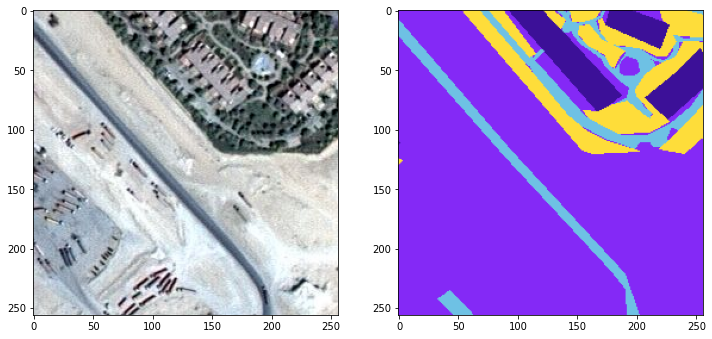

In [6]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [7]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152
Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246
Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228
Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58
Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41
Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [8]:
label = single_patch_mask

In [9]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg [np.all(label == Building, axis = -1)] = 0
    label_seg [np.all(label == Land, axis = -1)] = 1
    label_seg [np.all(label == Road, axis = -1)] = 2    
    label_seg [np.all(label == Vegetation, axis = -1)] = 3    
    label_seg [np.all(label == Water, axis = -1)] = 4    
    label_seg [np.all(label == Unlabeled, axis = -1)] = 5
    
    label_seg = label_seg[:,:,0]
    
    return label_seg

In [10]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

In [11]:
labels = np.array(labels)

In [12]:
labels.shape

(1305, 256, 256)

In [13]:
labels = np.expand_dims(labels, axis=3)

In [14]:
labels.shape

(1305, 256, 256, 1)

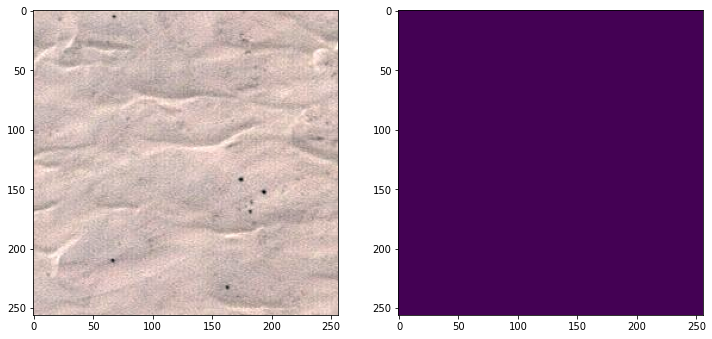

In [15]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number])
plt.show()

In [16]:
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, n_classes)
labels_cat.shape

(1305, 256, 256, 6)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [19]:
del image_dataset, mask_dataset, labels_cat, labels,

NameError: name 'image_dataset' is not defined

In [20]:
def multi_unet_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [21]:
model = multi_unet_model()
model.summary()

2022-11-20 21:29:32.535437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 21:29:32.536412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 21:29:32.889054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 21:29:32.889973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 21:29:32.890812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 1, 
                    verbose=1,
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

2022-11-20 21:30:24.521871: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 821035008 exceeds 10% of free system memory.
2022-11-20 21:30:25.444252: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1642070016 exceeds 10% of free system memory.
2022-11-20 21:30:27.558494: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 821035008 exceeds 10% of free system memory.
2022-11-20 21:30:28.233314: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1642070016 exceeds 10% of free system memory.
2022-11-20 21:30:29.671234: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-20 21:30:33.061463: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1042/1044 [============================>.] - ETA: 0s - loss: 0.9019 - accuracy: 0.6782

2022-11-20 21:30:59.229572: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 410517504 exceeds 10% of free system memory.


1044/1044 [==============================] - 31s 16ms/step - loss: 0.9017 - accuracy: 0.6783 - val_loss: 0.7186 - val_accuracy: 0.7526
Epoch 2/10
1044/1044 [==============================] - 15s 15ms/step - loss: 0.7529 - accuracy: 0.7423 - val_loss: 0.6630 - val_accuracy: 0.7662
Epoch 3/10
1044/1044 [==============================] - 15s 15ms/step - loss: 0.6727 - accuracy: 0.7708 - val_loss: 0.6469 - val_accuracy: 0.7743
Epoch 4/10
1044/1044 [==============================] - 17s 16ms/step - loss: 0.6364 - accuracy: 0.7852 - val_loss: 0.6145 - val_accuracy: 0.7897
Epoch 5/10
1044/1044 [==============================] - 16s 15ms/step - loss: 0.6115 - accuracy: 0.7949 - val_loss: 0.6059 - val_accuracy: 0.7931
Epoch 6/10
1044/1044 [==============================] - 16s 15ms/step - loss: 0.5807 - accuracy: 0.8071 - val_loss: 0.5570 - val_accuracy: 0.8126
Epoch 7/10
1044/1044 [==============================] - 16s 15ms/step - loss: 0.5665 - accuracy: 0.8123 - val_loss: 0.5395 - val_accura

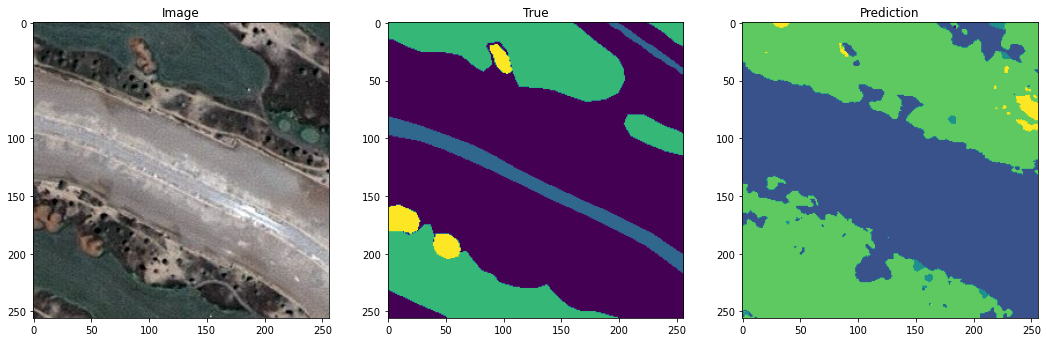

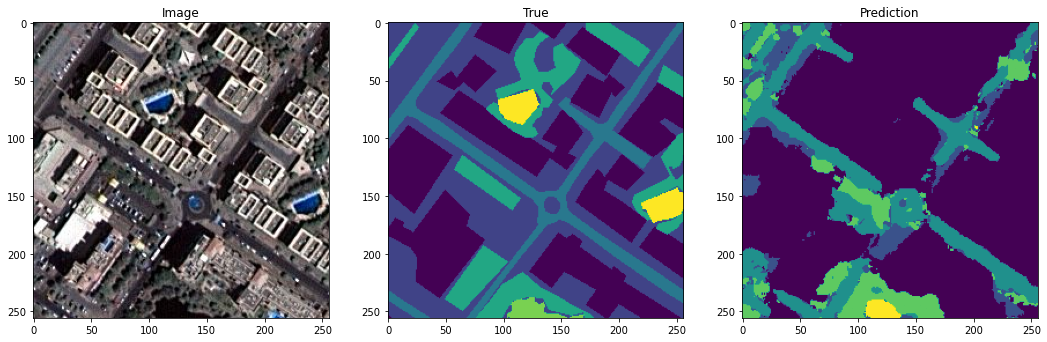

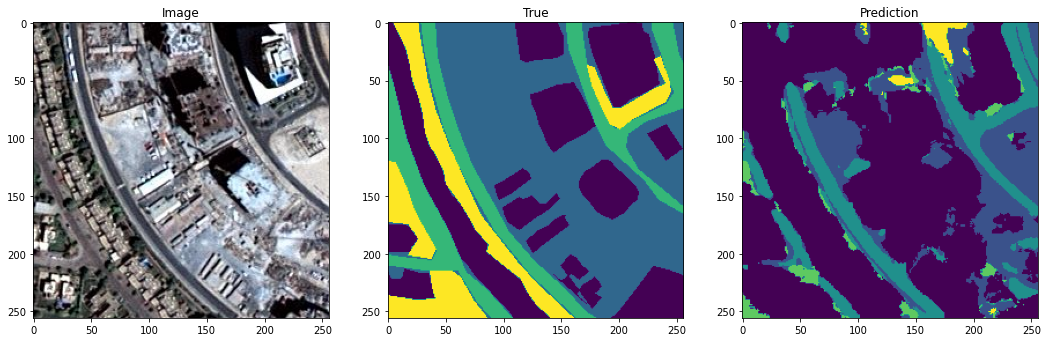

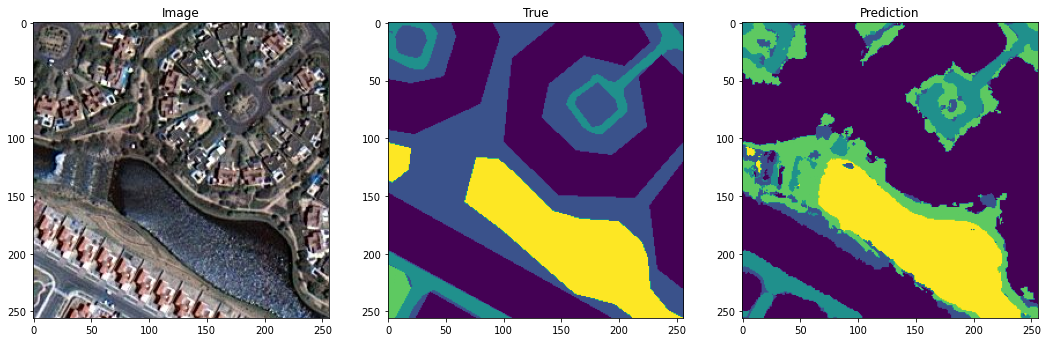

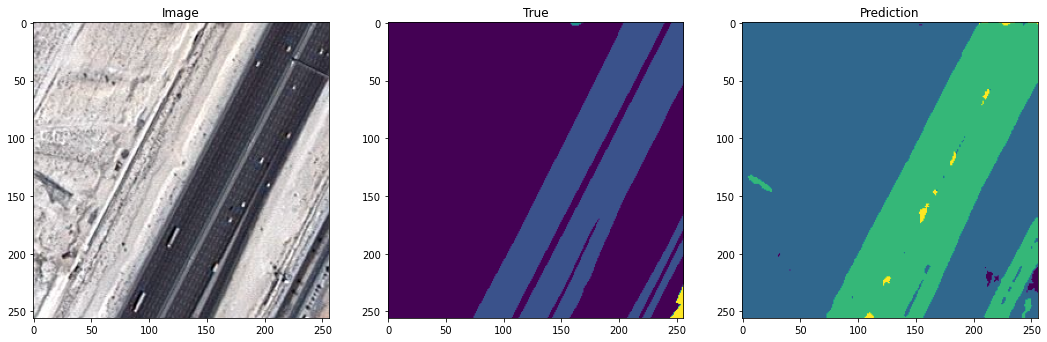

In [61]:
for i in range(5):
    image_number = random.randint(0, X_test.shape[0])
    plt.figure(figsize=(18, 6))
    
    plt.subplot(131)
    plt.title('Image')
    plt.imshow(X_test[image_number])
    
    plt.subplot(132)
    plt.title('True')
    plt.imshow(y_test[image_number].argmax(axis=2))
    
    plt.subplot(133)
    plt.title('Prediction')
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2)
    plt.imshow(prediction)
    plt.show()